# Exercise 4: Logistic Regression, Bayes and EM

In this assignment you will implement several algorithms as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in this notebook only. **Do not create Python modules and import them**.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) and pandas. 
6. Your code must run without errors. During the environment setup, you were given a specific version of `numpy` to install (1.15.4). Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
7. Write your own code. Cheating will not be tolerated.
8. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw4_123456789_987654321.ipynb` if you submitted in pairs and `hw4_123456789.ipynb` if you submitted the exercise alone.
9. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will not be checked.

## In this exercise you will perform the following:
1. Implement Logistic Regression algorithm.
1. Implement EM algorithm.
1. Implement Navie Bayes algorithm that uses EM for calculating the likelihood.
1. Visualize your results.

# I have read and understood the instructions: *** 203459011 ***

In [1]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function for plotting the decision boundaries of a model
# You will use it later
def plot_decision_regions(X, y, classifier, resolution=0.01):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Reading the data

In [3]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

## Visualizing the data
(2 points each - 8 points total)

Plot the following graphs for the training set:

For the first feature only:
1. For the first 1000 data points plot a histogram for each class on the same graph (use bins=20, alpha=0.5).
1. For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).

For both features:
1. For the first 1000 data points plot a scatter plot where each class has different color
1. For all the data points plot a scatter plot where each class has different color

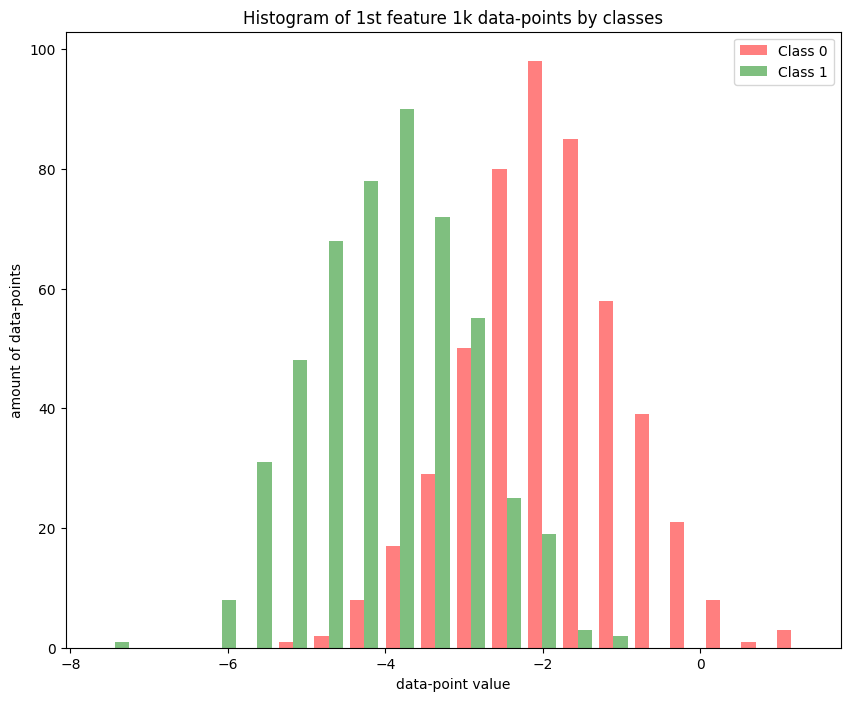

In [4]:
#first feature 1k plot (bins=20, alpha=0.5)
X1_1k , y_1k= X_training[:1000 , 0], y_training[:1000]
X1_1k_class_0 = X1_1k[y_1k ==0]
X1_1k_class_1 = X1_1k[y_1k ==1]
plt.hist([X1_1k_class_0, X1_1k_class_1], bins=20, alpha=0.5, label=['Class 0', 'Class 1'], color=['r','g'])
plt.legend()
plt.xlabel('data-point value')
plt.ylabel('amount of data-points')
plt.title('Histogram of 1st feature 1k data-points by classes')
plt.show()


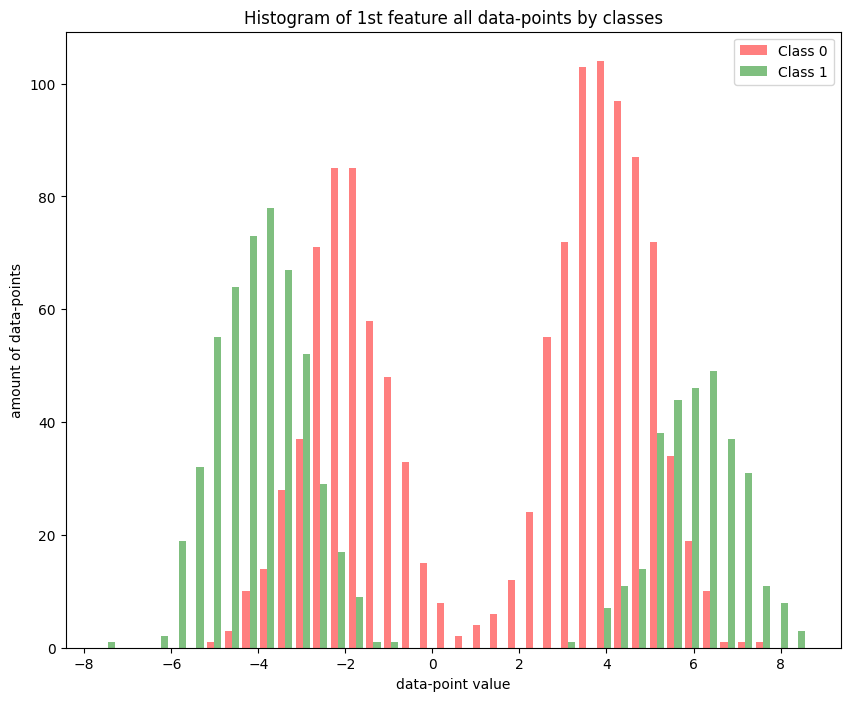

In [5]:
#first feature all points plot (bins=40, alpha=0.5)
X1_1k , y_1k= X_training[: , 0], y_training[:]
X1_1k_class_0 = X1_1k[y_1k ==0]
X1_1k_class_1 = X1_1k[y_1k ==1]
plt.hist([X1_1k_class_0, X1_1k_class_1], bins=40, alpha=0.5, label=['Class 0', 'Class 1'], color=['r','g'])
plt.legend()
plt.xlabel('data-point value')
plt.ylabel('amount of data-points')
plt.title('Histogram of 1st feature all data-points by classes')
plt.show()

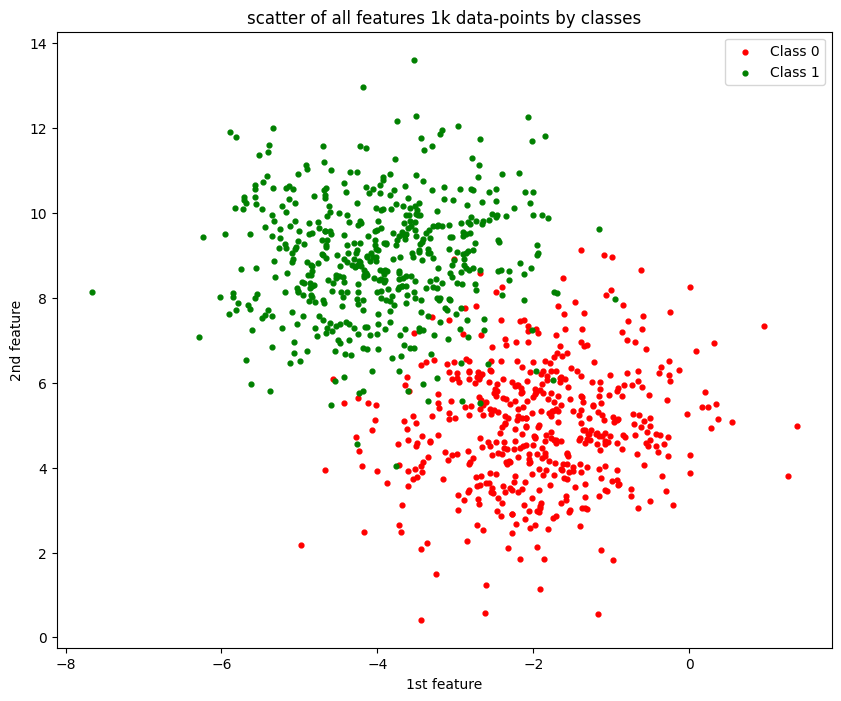

In [6]:
#all features first 1k scatter
X_1k , y_1k= X_training[:1000], y_training[:1000]
X_1k_class_0 = X_1k[y_1k ==0]
X_1k_class_1 = X_1k[y_1k ==1]
plt.scatter(x=X_1k_class_0[:,0], y=X_1k_class_0[:,1], s=12, color=['r'], label='Class 0')
plt.scatter(x=X_1k_class_1[:,0], y=X_1k_class_1[:,1], s=12, color=['g'], label='Class 1')
plt.legend()
plt.xlabel('1st feature')
plt.ylabel('2nd feature')
plt.title('scatter of all features 1k data-points by classes')
plt.show()


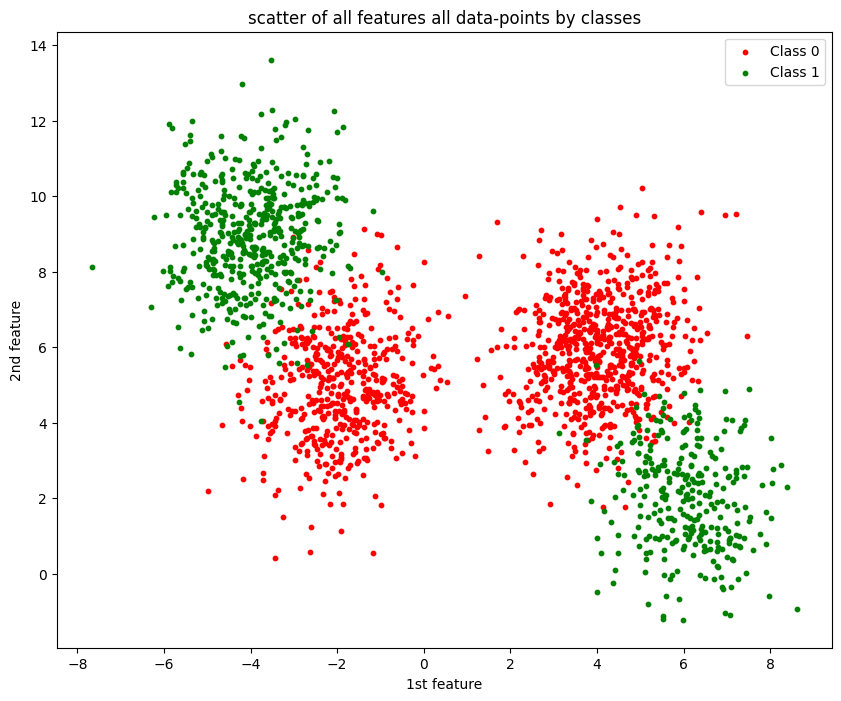

In [7]:
#all features scatter
X_1k , y_1k= X_training[:], y_training[:]
X_1k_class_0 = X_1k[y_1k ==0]
X_1k_class_1 = X_1k[y_1k ==1]
plt.scatter(x=X_1k_class_0[:,0], y=X_1k_class_0[:,1], s=10, color=['r'], label='Class 0')
plt.scatter(x=X_1k_class_1[:,0], y=X_1k_class_1[:,1], s=10 ,color=['g'], label='Class 1')
plt.legend()
plt.xlabel('1st feature')
plt.ylabel('2nd feature')
plt.title('scatter of all features all data-points by classes')
plt.show()

## Logistic Regression

(15 Points)

Implement the Logistic Regression algorithm that uses gradient descent for finding the optimal theta vector. 

Where:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

$$
J(\theta)=\frac{1}{m} \sum_{d=1}^{m} - y^{(d)}ln(h_\theta(x^{(d)}) - (1 - y^{(d)})ln(1 - h_\theta(x^{(d)})
$$

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance after the fit function was executed

\* You can add more functions if you think this is necessary

Your model should also store a list of the costs that you've calculated in each iteration

In [12]:
class LogisticRegressionGD(object):
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """
    
    def __init__(self, eta=0.00005, n_iter=10_000, eps=0.000001, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state
        self.theta = None
        self.cost_hist = []

    def fit(self, X, y):
        """ 
        Fit training data (the learning phase).
        Updating the theta vector in each iteration using gradient descent.
        Store the theta vector in an attribute of the LogisticRegressionGD object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        """
        # bias trick on dataset X
        X = np.column_stack((np.ones(X.shape[0]), X))
        # initiate rand theta
        np.random.seed(self.random_state)
        self.theta = np.random.randn(X.shape[1])
        # gradient descent
        for iteration in range(self.n_iter):
            # calculate current theta cost
            self.cost_hist.append(self.compute_cost(X,y))
            print(self.cost_hist[-1])

            if iteration > 0 and abs(self.cost_hist[-1] - self.cost_hist[-2]) < self.eps:
                break
            # evaluate new theta
            self.theta = self.theta - (self.eta * np.dot(X.T, (self.sigmoid(X) - y) ))


    def compute_cost(self, x, y):
        """calculate the cost function vectorized"""
        sigmoid = self.sigmoid(x)
        cost_0_when_1 = -y * np.log(sigmoid)
        cost_1_when_0 = - (1-y) * np.log(1-sigmoid)
        cost = np.mean(cost_0_when_1 + cost_1_when_0)
        return cost

    def sigmoid(self, v):
        """calculate the sigmoid for a given vector with current theta"""
        return 1 / (1 + np.exp(-1 * np.dot( v , self.theta.T)))


    def predict(self, X):
        """Return the predicted class label"""
        if len(X.shape) == 1:
            X = np.array([X])
        # bias trick
        X = np.column_stack((np.ones(X.shape[0]), X))
        # theta is saved in self.theta (latest is the most updated)
        prob = self.sigmoid(X)
        # prob is a vector with probability [0-1], need to over-ride
        prob[prob > 0.5] = 1
        prob[prob <= 0.5] = 0
        return prob


In [13]:
def model_accuracy(trained_model, X_val, y_val):
    """
    returns accuracy of the model avg of prediction (#correct predictions / #all data-points)
    """
    predict_labels = trained_model.predict(X_val)
    return np.sum(predict_labels == y_val) / len(X_val)

In [10]:
# test code
#
# model1 = LogisticRegressionGD(eta=0.05, eps=0.01)
# model1.fit(X_training,y_training)
# print(model_accuracy(model1, X_test, y_test))
# model2 = LogisticRegressionGD(eta=5e-05, eps=1e-06)
# model2.fit(X_training,y_training)
# print(model_accuracy(model2, X_test, y_test))




In [14]:
lor = LogisticRegressionGD()
lor.fit(X_training, y_training)
predictions_x_train = lor.predict(X_training)
predictions_x_test = lor.predict(X_test)
print("pred train/test ",predictions_x_train)
savetxt('data2.csv', predictions_x_train, delimiter=',')
np.sum(lor.predict(X_training) == y_training) / len(X_training), np.sum(lor.predict(X_test) == y_test) / len(X_test)
# X_training, y_training

AttributeError: 'LogisticRegressionGD' object has no attribute 'cost_history'

In [ ]:
# test code

model1 = LogisticRegressionGD(eta=0.05, eps=0.01)
model1.fit(X_training,y_training)
pred = model1.predict(X_test)
# print(X_test[0])
# print(pred)
# print(y_test)
# print(model_accuracy(model1, X_test, y_test))
# model2 = LogisticRegressionGD(eta=5e-05, eps=1e-06)
# model2.fit(X_training,y_training)
# print(model_accuracy(model2, X_test, y_test))




## Cross Validation

(5 points)

Use 5-fold cross validation in order to find the best eps and eta params from the given lists.

Shuffle the training set before you split the data to the folds.

In [11]:
#### Your code here ####
etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]
fold_number = 5
#  todo

# shuffle the indices in place
np.random.seed(42)
training_set_shuffled = training_set.values
np.random.shuffle(training_set_shuffled)
# split the shuffled training data to k groups (k=5)
folds_split = np.array_split(training_set_shuffled, fold_number)

# each fold as validation set and its matching training set
# every validation set has its matching training in the same index
training_fold_sets = []
validation_fold_sets = []

#each training will have 1600 data-points and validation will have 400 data-points
for fold_idx, fold_values in enumerate(folds_split):
    training_without_validate = np.concatenate(np.delete(folds_split, fold_idx, axis=0))
    X_train_cur, y_train_cur = training_without_validate[:, :2], training_without_validate[:, 2]
    X_validate_cur, y_validate_cur = fold_values[:, :2], fold_values[:, 2]
    training_fold_sets.append((X_train_cur, y_train_cur))
    validation_fold_sets.append((X_validate_cur, y_validate_cur))

# measure avg cost of each combination eta & eps using cross-validations
# default values to start loops
iter_num = 10_000
best_eta = None
best_eps = None
best_accuracy = -1.0
print('Start finding best eta and eps values...')
for eta in etas:
    for eps in epss:
        current_accuracy = 0.0
        for i in range(fold_number):
            X_train_cur, y_train_cur = training_fold_sets[i]
            X_validate_cur, y_validate_cur = validation_fold_sets[i]
            model = LogisticRegressionGD(eta=eta, n_iter=iter_num, eps=eps)
            model.fit(X_train_cur, y_train_cur)
            current_accuracy += model_accuracy(model, X_validate_cur, y_validate_cur)
        # calculate avg accuracy of cross validation process
        current_accuracy = current_accuracy / fold_number
        # test loop
        # print(f'eta: {eta}, eps: {eps}, avg accuracy: {current_accuracy}')
        if current_accuracy > best_accuracy:
            best_eta = eta
            best_eps = eps
            best_accuracy = current_accuracy
            # for test
            # print(f'best updated... best eta: {best_eta}, best eps: {best_eps}, with avg accuracy of: {best_accuracy}')
print('Process completed!\n')
print('*********************************')
print(f'best eta: {best_eta}, best eps: {best_eps}, with avg accuracy of: {best_accuracy}')
print('*********************************')

Start finding best eta and eps values...


KeyboardInterrupt: 

## Normal distribution pdf

(2 Points)

Implement the normal distribution pdf 
$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}
$$
Write an efficient vectorized code

In [ ]:
#### Your code here ####
# calc normal pdf
def norm_pdf(data, mu, sigma):
    numerator = np.exp(-0.5 * np.power((data - mu)/sigma, 2))
    denominator = sigma * np.sqrt(2 * np.pi)
    return numerator / denominator

## Expectation Maximization

(15 Points)

Implement the Expectation Maximization algorithm for gaussian mixture model.

The class should hold the distribution params.

Use -log likelihood as the cost function:
$$
cost(x) = \sum_{d=1}^{m}-log(w * pdf(x; \mu, \sigma))
$$

\* The above is the cost of one gaussian. Think how to use the cost function for gaussian mixture.

Your class should contain the following functions:
1. init_params - initialize distribution params
1. expectation - calculating responsibilities
1. maximization - updating distribution params
1. fit - the learning function
1. get_dist_params - return the distribution params

\* You can add more functions if you think this is necessary

Don't change the eps params (eps=0.01)

When you need to calculate the pdf of a normal distribution use the function `norm_pdf` that you implemented above.

In [ ]:
# test box
# np.array([[2,4],[6,9],[10,20],[30,40],[50,60]]) / np.array([2,3,5,2,2])[:,None]

In [ ]:
class EM(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM proccess
    eps: float
      minimal change in the cost to declare convergence

    """
    
    def __init__(self, k=1, n_iter=1_000, eps=0.01):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps
        self.mean = np.array([])
        self.std = np.array([])
        self.weight = np.empty(k)
        self.cost_history = []
        self.g_responsibilities = None

    # initial guesses for parameters
    def init_params(self, data):
        """
        Initialize distribution params
        """
        split_data = np.array_split(data, self.k)
        # init assumption is equal distribution params
        self.weight.fill(1/self.k)
        split_data = np.array_split(data, self.k)
        # for every gaussian we compute initial mean, std
        for data in split_data:
            self.mean = np.append(self.mean, np.mean(data))
            self.std = np.append(self.std, np.std(data))

    def expectation(self, data):
        """
        E step - calculating responsibilities
        """
        # rows- data-points, columns - different gaussian
        self.g_responsibilities = np.zeros((len(data), self.k))

        for gaus in range(self.k):
            #update each data point how each Gaussian is contributing to its presence. (prior * post)
            self.g_responsibilities[:,gaus] = self.weight[gaus] * norm_pdf(data, self.mean[gaus], self.std[gaus])
        # dividing by prob to see P(x) -> x is a datapoint
        gaus_weights = self.g_responsibilities.sum(axis=1)[:, None]
        self.g_responsibilities = self.g_responsibilities / gaus_weights

    def maximization(self, data):
        """
        M step - updating distribution params vectorized version
        """
        self.weight = self.g_responsibilities.mean(axis=0)
        self.mean = np.dot(data, self.g_responsibilities/len(data)) / self.weight
        # self.std = np.sqrt()

        data_duplicated = np.array([data for _ in range(self.k)]).T
        self.std = np.sqrt((((data_duplicated - self.mean)**2) * self.g_responsibilities).mean(axis=0) / self.weight)

    def compute_cost(self, data):
        """cost function - log probability"""
        cost_array = np.zeros(self.k)
        for gaus in range(self.k):
            cost_array[gaus] = - np.log(self.weight[gaus] * norm_pdf(data, self.mean[gaus], self.std[gaus])).sum()
        return cost_array

    def fit(self, data):
        """ 
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params 
        for the distribution. 
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """
        self.init_params(data)
        self.cost_history = [self.compute_cost(data)]
        for iteration in range(self.n_iter):
            if iteration > 0 and np.max(abs(self.cost_history[-1] - self.cost_history[-2])) < self.eps:
                break
            self.expectation(data)
            self.maximization(data)
            self.cost_history.append(self.compute_cost(data))

    def get_dist_params(self):
        """return as a tuple (mean, std, weights)"""
        return self.mean, self.std, self.weight


## Naive Bayes

(15 Points)

Implement the Naive Bayes algorithm.

For calculating the likelihood use the EM algorithm that you implemented above to find the distribution params. With these params you can calculate the likelihood probability.

Calculate the prior probability directly from the training set.

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance (or instances) after the fit function was executed

\* You can add more functions if you think this is necessary


In [ ]:
class NaiveBayesGaussian(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension

    """

    def __init__(self, k=1):
        self.k = k
        self.labels = np.array([])
        self.priors = np.array([])
        self.params = dict()


    def fit(self, X, y):
        """ 
        Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """
        #extract unique labels from data
        self.labels = np.unique(y)
        # update priors
        for label in self.labels:
            tmp = np.where(y == label)[0].shape[0] / y.shape[0]
            self.priors = np.append(self.priors, tmp )

        # practice each feature by EM model with k attribute
        for label in self.labels:
            X_of_label = X[y == label]
            for feature in range(X.shape[1]):
                X_feature_of_label = X_of_label[:,feature]
                em_model = EM(self.k)
                em_model.fit(X_feature_of_label)
                self.params[(feature, label)] = em_model.get_dist_params()

    def predict(self, X):
        """Return the predicted class label"""
        if len(X.shape) == 1:
            X = np.array([X])
        # perform likelihood estimation
        likelihood_mat = []
        for label in self.labels:
            likelihood_of_label = np.zeros(X.shape)
            for feature in range(X.shape[1]):
                mean, std, weights = self.params[(feature, label)]
                for i in range(self.k):
                    likelihood_of_label[:, feature] += weights[i] * norm_pdf(X[:, feature], mean[i], std[i])
            likelihood_mat.append(np.prod(likelihood_of_label, axis=1))

        prediction = np.empty(X.shape[0])
        for instance_idx, instance in enumerate(X):
            #(label, probability to be in the label)
            most_likely_label = (None, -1)
            for label_idx, label in enumerate(self.labels):
                prior = self.priors[label_idx]
                likelihood_cur = likelihood_mat[label_idx][instance_idx]
                prob = prior * likelihood_cur
                if prob > most_likely_label[1]:
                    most_likely_label = (label, prob)
            prediction[instance_idx] = most_likely_label[0]
        return prediction


## Model evaluation

(20 points)

In this section you will build 2 models and fit them to 2 datasets

First 1000 training points and first 500 test points:
1. Use the first 1000 points from the training set (take the first original 1000 points - before the shuffle) and the first 500 points from the test set.
1. Fit Logistic Regression model with the best params you found earlier.
1. Fit Naive Bayes model. Remember that you need to select the number of gaussians in the EM.
1. Print the training and test accuracies for each model.
1. Use the `plot_decision_regions` function to plot the decision boundaries for each model (for this you need to use the training set as the input)
1. Plot the cost Vs the iteration number for the Logistic Regression model

Use all the training set points:
1. Repeat sections 2-6 for all the training set points
1. Provide one or two sentences on each graph explaining what you observe in the graph.

#### Don't forget to label your graphs ####

In [ ]:
#### Your code here ####
# we will use the assumption of k=2 as guessed from visualizing data above
#initiate models to compare
X_train_1k = X_training[:1000]
y_train_1k = y_training[:1000]

X_test_500   = X_test[:500]
y_test_500   = y_test[:500]

naive_em_model = NaiveBayesGaussian(k=2)
logistic_model = LogisticRegressionGD(eta=best_eta, eps=best_eps)
# training models
naive_em_model.fit(X_train_1k, y_train_1k)
logistic_model.fit(X_train_1k, y_train_1k)

logistic_accuracy_on_1k_training = model_accuracy(logistic_model, X_train_1k, y_train_1k)
logistic_accuracy_on_500_test = model_accuracy(logistic_model, X_test_500, y_test_500)

naive_em_accuracy_on_1k_training = model_accuracy(naive_em_model, X_train_1k, y_train_1k)
naive_em_accuracy_on_500_test = model_accuracy(naive_em_model, X_test_500, y_test_500)


**************************************************
*       Logistic Regression Model 1k             *
**************************************************
Logistic Regression model accuracy on 1k from training: 0.965
Logistic Regression model accuracy on 500 from test: 0.938


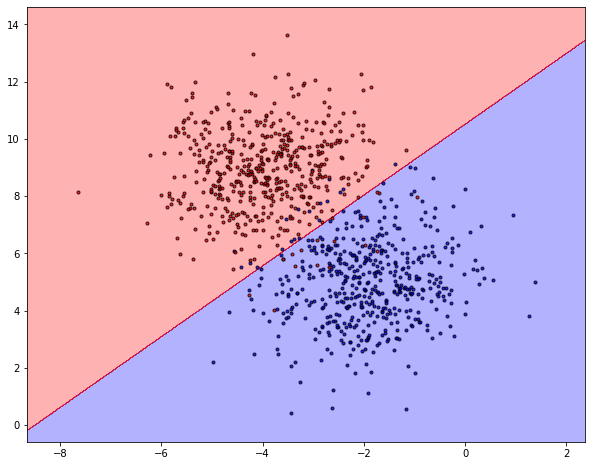

In [ ]:
# plotting logistic regression data on 1k
print("**************************************************")
print("*       Logistic Regression Model 1k             *")
print("**************************************************")
print(f'Logistic Regression model accuracy on 1k from training: {logistic_accuracy_on_1k_training}')
print(f'Logistic Regression model accuracy on 500 from test: {logistic_accuracy_on_500_test}')
plot_decision_regions(X_train_1k, y_train_1k, logistic_model)


### 1. Decision boundaries - Logistic Regression model
The data in our 1k training set is linearly separable, therefore the logistic model converge.


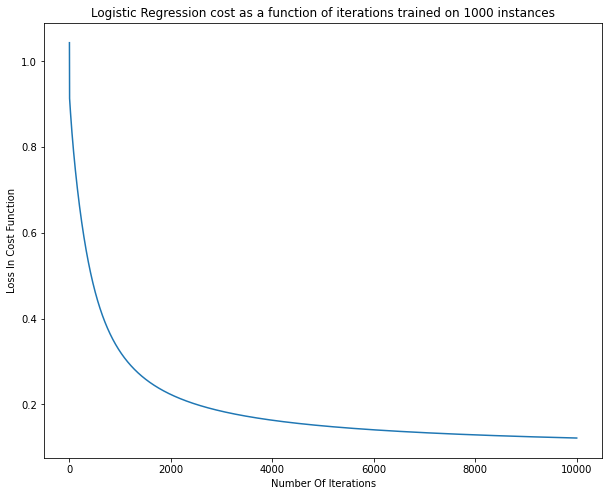

In [ ]:
plt.plot(list(range(len(logistic_model.cost_hist))), logistic_model.cost_hist)
plt.title("Logistic Regression cost as a function of iterations trained on 1000 instances")
plt.ylabel('Loss In Cost Function')
plt.xlabel("Number Of Iterations")
plt.show()

### 2. Number of iterations VS Cost - Logistic Regression model
We are quickly getting good result after 4,000 iterations, the learning curve to flatten.

**************************************************
*           Naive Bayes Model 1k                 *
**************************************************
Naive Bayes Model accuracy on 1k from training: 0.968
Naive Bayes Model accuracy on 500 from test: 0.942


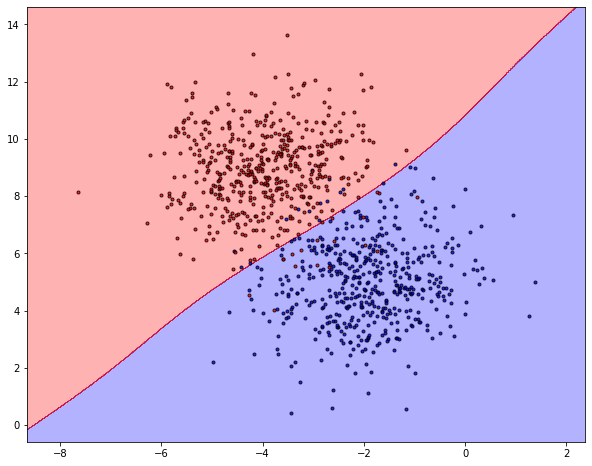

In [ ]:
print("**************************************************")
print("*           Naive Bayes Model 1k                 *")
print("**************************************************")
print(f'Naive Bayes Model accuracy on 1k from training: {naive_em_accuracy_on_1k_training}')
print(f'Naive Bayes Model accuracy on 500 from test: {naive_em_accuracy_on_500_test}')
plot_decision_regions(X_train_1k, y_train_1k, naive_em_model)

### 3. Decision boundaries - Naive Bayes model
The data in our 1k training set is achieve high result by the naive assumption that all features are i.i.d, which may seem as correct assumption.


## Training Models On All Data

In [ ]:
# we will use the assumption of k=2 as guessed from visualizing data above
#initiate models to compare

naive_em_model_full = NaiveBayesGaussian(k=2)
logistic_model_full = LogisticRegressionGD(eta=best_eta, eps=best_eps)
# training models on full data set
naive_em_model_full.fit(X_training, y_training)
logistic_model_full.fit(X_training, y_training)

logistic_accuracy_full_training = model_accuracy(logistic_model_full, X_training, y_training)
logistic_accuracy_full_test = model_accuracy(logistic_model_full, X_test, y_test)

naive_em_accuracy_full_training = model_accuracy(naive_em_model_full, X_training, y_training)
naive_em_accuracy_full_test = model_accuracy(naive_em_model_full, X_test, y_test)

**************************************************
*      Logistic Regression Model full data       *
**************************************************
Logistic Regression model accuracy on 1k from training: 0.809
Logistic Regression model accuracy on 500 from test: 0.804


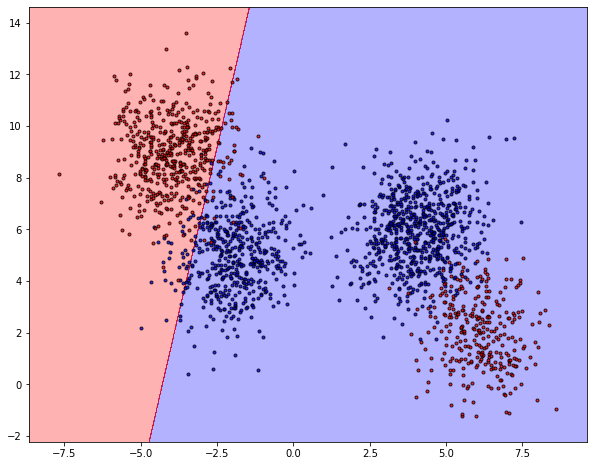

In [ ]:
# plotting logistic regression full data
print("**************************************************")
print("*      Logistic Regression Model full data       *")
print("**************************************************")
print(f'Logistic Regression model accuracy on 1k from training: {logistic_accuracy_full_training}')
print(f'Logistic Regression model accuracy on 500 from test: {logistic_accuracy_full_test}')
plot_decision_regions(X_training, y_training, logistic_model_full)


### 4. Decision boundaries - Logistic Regression model - full data
The full data is not fully linearly separable, therefore the logistic model has errors in classifying datapoints.


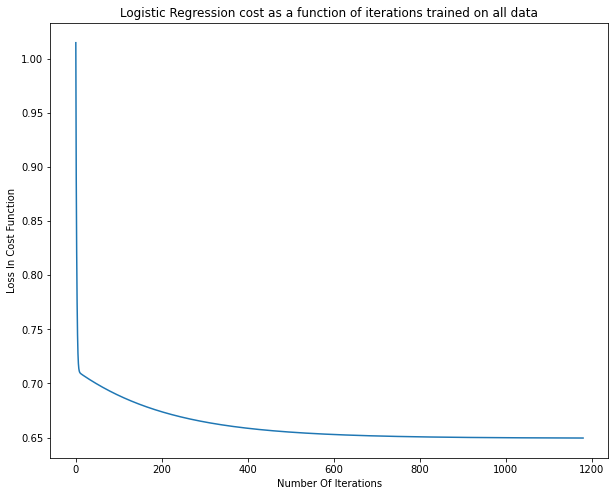

In [ ]:
plt.plot(list(range(len(logistic_model_full.cost_hist))), logistic_model_full.cost_hist)
plt.title("Logistic Regression cost as a function of iterations trained on all data")
plt.ylabel('Loss In Cost Function')
plt.xlabel("Number Of Iterations")
plt.show()

### 5. Number of iterations VS Cost - Logistic Regression model - full data
Our data is not linearly separable, so the loss function is bounded from below.

**************************************************
*           Naive Bayes Model full data          *
**************************************************
Naive Bayes Model accuracy full data training: 0.9215
Naive Bayes Model accuracy full test: 0.902


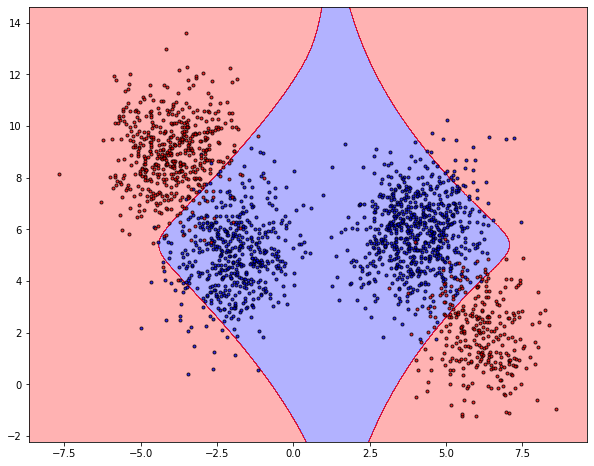

In [ ]:
print("**************************************************")
print("*           Naive Bayes Model full data          *")
print("**************************************************")
print(f'Naive Bayes Model accuracy full data training: {naive_em_accuracy_full_training}')
print(f'Naive Bayes Model accuracy full test: {naive_em_accuracy_full_test}')
plot_decision_regions(X_training, y_training, naive_em_model_full)

### 6. Decision boundaries - Naive Bayes model - full data
Again by achieving high result by the naive assumption that all features are i.i.d stands. here we can see it perform better than logistic, more likely the data is distributed normally, so our EM gaussian model is good fit for it.


## Open question

(20 points) 

1. In this homework we explored two types of models: Naive Bayes using EM, and Logistic regression.  
   1. Generate a dataset, in 3 dimensions (3 features), with 2 classes, using **only** Multivariate-Gaussians (as many as you want) that you think **Naive Bayes will work better than Logisitc Regression**.
   2. Generate another dataset, in 3 dimensions (3 features), with 2 classes, using **only** Multivariate-Gaussians (as many as you want) that you think **Logistic Regression will work better than Naive Bayes**.
   
   - Explain the reasoning behind each dataset.  

2. Visualize the datasets.  
   You can choose one of two options for the visualization:
    1. Plot three 2d graphs of all the features against each other (feature1 vs feature2, feature1 vs feature3, feature2 vs feature3).
    2. Plot one 3d graph.

**Important Note**  
For this question only, you may use:  
```
from scipy.stats import multivariate_normal
```

#### Your code and explanations here ####


Text(0.5, 0, 'Feature #3')

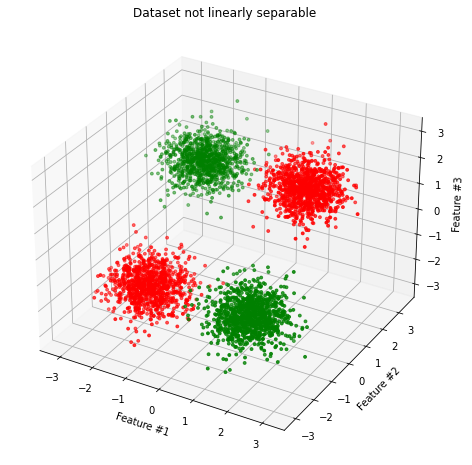

In [ ]:
label_0_a = np.random.normal(1.5, 0.5, 3000)
label_0_b = np.random.normal(-1.5, 0.5, 3000)

label_0_a = np.array(label_0_a).reshape((1000, 3))
label_0_b = np.array(label_0_b).reshape((1000, 3))

label_0 = np.concatenate((label_0_a, label_0_b))

# label_0 = np.column_stack((label_0, np.zeros(label_0.shape[0])))

label_1 = label_0 * np.array([-1,1,1])

# label_1 = np.array(label_1).reshape((1000,3))
#
# label_1 = np.column_stack((label_1, np.ones(label_1.shape[0])))

graph = plt.figure()
ax = graph.add_subplot(projection = "3d")
ax.scatter(label_0[:, 0], label_0[:, 1], label_0[:, 2], s=8, color='r')
ax.scatter(label_1[:,0], label_1[:,1], label_1[:,2], s=8, color='g')
ax.set_title("Dataset not linearly separable")
ax.set_xlabel("Feature #1")
ax.set_ylabel("Feature #2")
ax.set_zlabel("Feature #3")

## Naive Bayes is better
The dataset here is not linearly separable (I tried to make XOR shape), we need to increase number of dimensions so our logistic model will not find separation, while our naive EM might find the different gaussians of distribution for each class.

Text(0.5, 0, 'Feature #3')

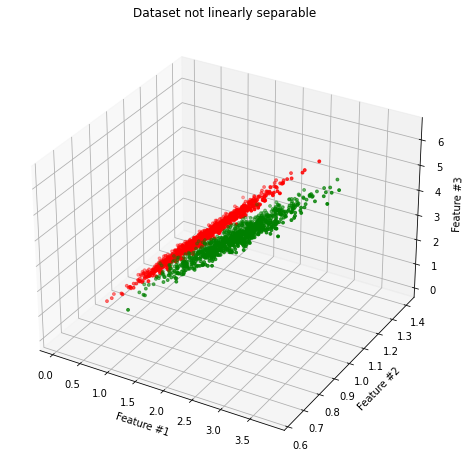

In [ ]:
label_0_a = np.array(np.random.normal(1.5, 0.5, 1000))
label_0_b = np.array(np.random.normal(1, 0.1, 1000))
label_0_c = 2 * label_0_a

label_0 = np.column_stack((label_0_a, label_0_b, label_0_c))

label_1_a = np.array(np.random.normal(2, 0.5, 1000))
label_1_b = np.array(np.random.normal(1, 0.1, 1000))
label_1_c = 1.6* label_1_a

label_1 = np.column_stack((label_1_a, label_1_b, label_1_c))



graph = plt.figure()
ax = graph.add_subplot(projection = "3d")
ax.scatter(label_0[:, 0], label_0[:, 1], label_0[:, 2], s=8, color='r')
ax.scatter(label_1[:,0], label_1[:,1], label_1[:,2], s=8, color='g')
ax.set_title("Dataset not linearly separable")
ax.set_xlabel("Feature #1")
ax.set_ylabel("Feature #2")
ax.set_zlabel("Feature #3")

## Logistic model is better
The dataset here is clearly linearly separable (different planes) so linear seperator is easily find. while EM assume that all features are i.i.d we manipulate the data that some features are dependent (linearly) on the others, we might have contradictions in math and more mistakes during maximization.